# Problem Set #7
- MACS 30150, Dr. Evans 
- Name: Kento Yoshizawa (CNET: kyoshizawa) 
- Date: February 26, 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline as LSQUS

## Question 1.

In [2]:
df = pd.read_csv('data/strongdrink.txt')
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 14 columns):
cultivar      176 non-null int64
alco          176 non-null float64
malic         176 non-null float64
ash           176 non-null float64
alk           176 non-null float64
magn          176 non-null int64
tot_phen      176 non-null float64
flav          176 non-null float64
nonfl_phen    176 non-null float64
proanth       176 non-null float64
color_int     176 non-null float64
hue           176 non-null float64
OD280rat      176 non-null float64
proline       176 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.3 KB


### (a)

In [4]:
X = df[['alco', 'malic', 'tot_phen', 'color_int']].values
y = df['cultivar'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20)

In [6]:
lr_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
coefs = lr_clf.coef_[:2].T
intercepts = lr_clf.intercept_[:2]

In [8]:
print('Estimated coefs. and intercepts for j = 1 and j = 2:')
pd.DataFrame(np.vstack([intercepts, coefs]),
            index = [r'$\beta_{j,0}$',r'$\beta_{j,1}$',r'$\beta_{j,2}$',r'$\beta_{j,3}$',r'$\beta_{j,4}$'],
            columns = [r'$j=1$',r'$j=2$'])

Estimated coefs. and intercepts for j = 1 and j = 2:


,$j=1$,$j=2$
"$\beta_{j,0}$",-24.027618,22.780733
"$\beta_{j,1}$",1.701735,-1.466297
"$\beta_{j,2}$",-0.265788,-0.332952
"$\beta_{j,3}$",1.224101,0.663556
"$\beta_{j,4}$",0.022507,-0.922682


In [9]:
y_pred = lr_clf.predict(X_test)
target_names = ['j = 1', 'j = 2', 'j = 3']
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

       j = 1       0.87      1.00      0.93        13
       j = 2       1.00      0.90      0.95        21
       j = 3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [10]:
for i,ps in enumerate(1 - precision_score(y_test, y_pred, average = None)):
    print('Error rate for j = {0}: {1:.3f}'.format(i+1,ps))

Error rate for j = 1: 0.133
Error rate for j = 2: 0.000
Error rate for j = 3: 0.000


In [11]:
np.unique(y, return_counts = True)

(array([1, 2, 3]), array([59, 71, 46]))

The most accurately predicted categories are $j=2, 3$ in terms of the precision. However, if we compare F1 score (i.e., the harmonic mean of precision and recall), $j = 3$ is the model best at predicting, which is with the least observations. Thus, we cannot say the category with the most observations is the most accurately predicted.

In [12]:
MSE_lr = (((y_test - y_pred)**2).sum())/y_test.shape[0]
print('MSE from the test set:{0:.4f}'.format(MSE_lr))

MSE from the test set:0.0455


### (b)

In [13]:
from sklearn.model_selection import LeaveOneOut

N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE_vec = np.zeros(N_loo)
y_pred = np.zeros(N_loo)

lr_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', max_iter = 500)
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr_clf.fit(X_train, y_train)
    y_pred[test_index] = lr_clf.predict(X_test)
    MSE_vec[test_index] = y_test != y_pred[test_index]

In [14]:
for i,ps in enumerate(1 - precision_score(y, y_pred, average = None)):
    print('Error rate for j = {0}: {1:.3f}'.format(i + 1,ps))

Error rate for j = 1: 0.098
Error rate for j = 2: 0.086
Error rate for j = 3: 0.044


While the error rate fot $j=1$ slightly decreases from part (a), other two error rates increase.

In [15]:
print('LOOCV estimate for test MSE: {0:.4f}'.format(MSE_vec.mean()))
print('Standard error             :({0:.4f})'.format(MSE_vec.std()))

LOOCV estimate for test MSE: 0.0795
Standard error             :(0.2706)


### (c)

In [16]:
from sklearn.model_selection import KFold
k = 4
kf = KFold(n_splits = k, random_state = 10, shuffle = True)
kf.get_n_splits(X)

lr_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', max_iter = 500)

MSE_vec_kf = np.zeros(k)
y_pred_kf = []
y_test_kf = []

k_ind = int(0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(X_test)
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    y_pred_kf.append(y_pred)
    y_test_kf.append(y_test)
    k_ind += 1

In [17]:
y_test = np.array(y_test_kf).flatten()
y_pred = np.array(y_pred_kf).flatten()
for i,ps in enumerate(1 - precision_score(y_test, y_pred, average = None)):
    print('Error rate for j = {0}: {1:.3f}'.format(i+1,ps))

Error rate for j = 1: 0.127
Error rate for j = 2: 0.088
Error rate for j = 3: 0.044


- Compared to part (a): While the error rate fot $j=1$ slightly decreases, other two error rates increase. 
- Compared to part (b): Every error rate are almost the same.

In [18]:
print('k-fold estimate for test MSE: {0:.4f}'.format(MSE_vec_kf.mean()))
print('Standard error              :({0:.4f})'.format(MSE_vec_kf.std()))

k-fold estimate for test MSE: 0.0909
Standard error              :(0.0482)


## Question 2.

In [19]:
data = np.loadtxt('data/CoolIndex.txt',delimiter = ',')
data.shape

(956, 2)

### (a)

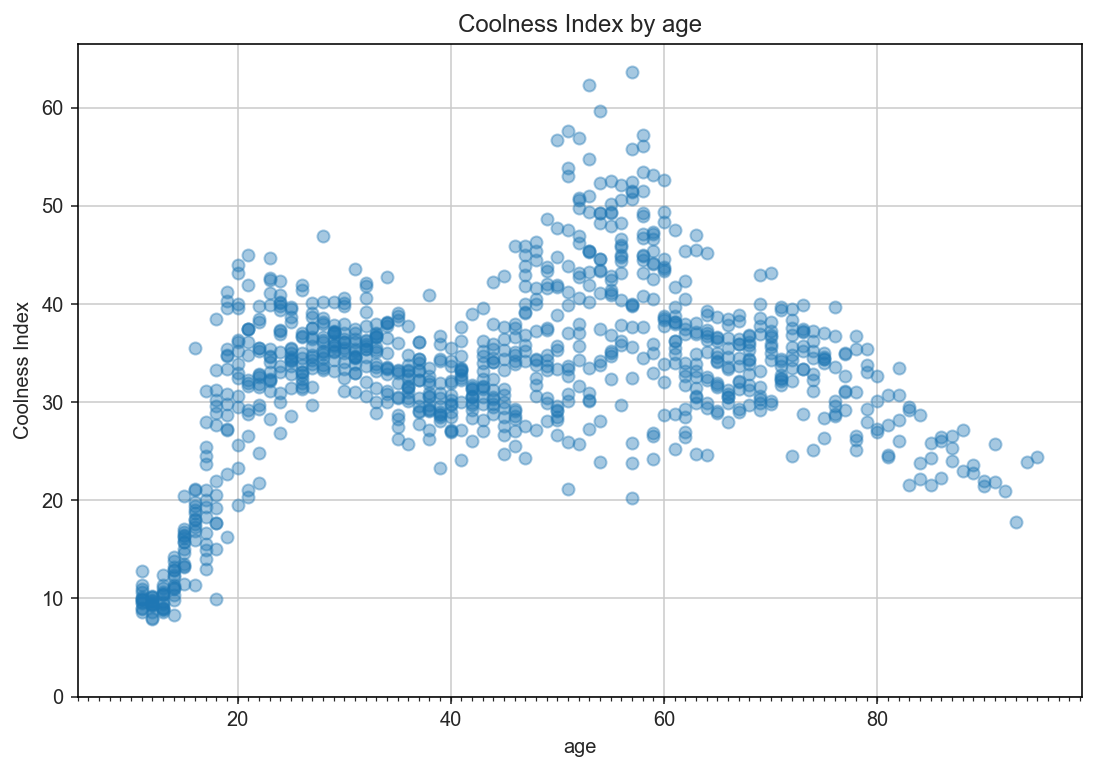

In [20]:
sns.set_style('whitegrid',{'axes.edgecolor': 'k', "xtick.bottom" : True, "ytick.left" : True})
# sns.set_context('talk')
fig, ax = plt.subplots(figsize = (9, 6))
plt.scatter(data[:,0], data[:,1], alpha = 0.4)
plt.title('Coolness Index by age')
plt.xlabel('age')
plt.ylabel('Coolness Index')
plt.ylim(0)
ax.set_xticks(np.arange(5,100), minor=True);

### (b)

In [21]:
bins = [11, 22, 40, 59, 77, 96]
dummys = np.zeros((data.shape[0], 5))
for i in range(5):
    dummys[:, i] = np.array([(data[:,0] >= bins[i]) & (data[:,0] < bins[i+1])])

In [22]:
reg = sm.OLS(data[:,1], dummys)
result = reg.fit()
stepwise = result.params

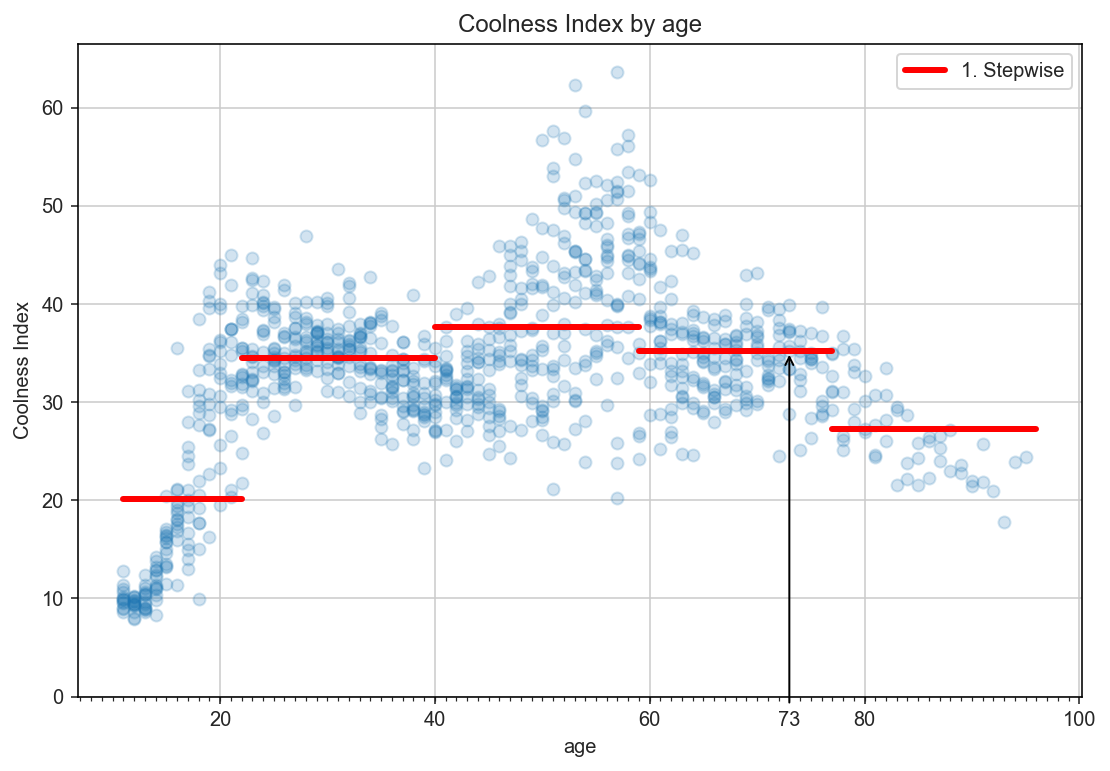

In [23]:
cool73 = stepwise[3]

fig, ax = plt.subplots(figsize = (9, 6))
## Cool
plt.scatter(data[:,0], data[:,1], alpha = 0.2)
plt.title('Coolness Index by age')
plt.xlabel('age')
plt.ylabel('Coolness Index')
plt.ylim(0)
ax.set_xticks(np.arange(5,100), minor=True)

## 1. Stepwise
for i in range(4):
    plt.plot((bins[i], bins[i+1]), (stepwise[i],stepwise[i]), c = 'r', linewidth = 3)
plt.plot((bins[4], bins[5]), (stepwise[4],stepwise[4]), c = 'r', linewidth = 3, label = '1. Stepwise')
plt.legend()

## Coolness of 73-years old 
plt.annotate('73', (73.0, cool73), (73.0, -3), arrowprops=dict(arrowstyle='->', ec = 'k'),ha='center');

In [24]:
print('Estimated stepwise function values:')
for i in range(5):
    print(' - beta_{0}: {1:.2f}'.format(i+1, stepwise[i]))
print('\nPredicted coolness of a 73-year old: {0:.2f}'.format(cool73))

Estimated stepwise function values:
 - beta_1: 20.10
 - beta_2: 34.48
 - beta_3: 37.64
 - beta_4: 35.23
 - beta_5: 27.30

Predicted coolness of a 73-year old: 35.23


### (c)

In [25]:
xvals = np.sort(np.unique(data[:,0]))
yvals = np.array([data[:,1][data[:,0] == i].mean() for i in xvals])
spl1 = LSQUS(xvals, yvals, t = [22, 40, 59, 77], k = 1)

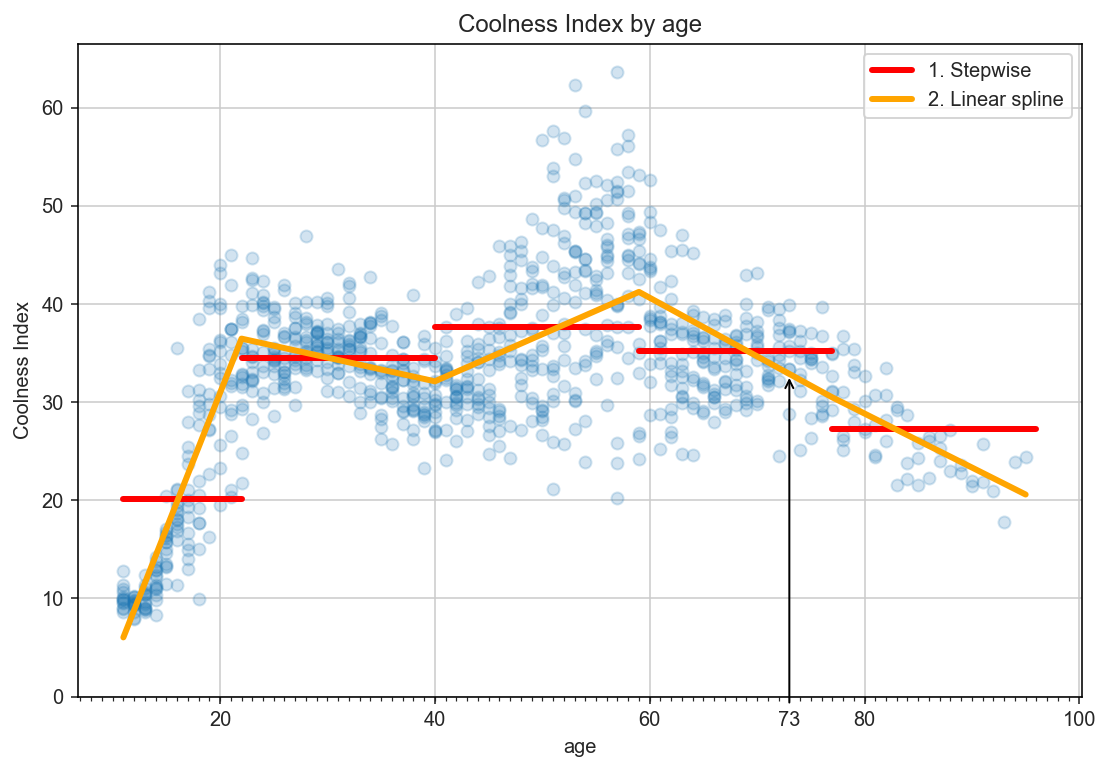

In [26]:
cool73 = spl1(73)

fig, ax = plt.subplots(figsize = (9, 6))
## Cool
plt.scatter(data[:,0], data[:,1], alpha = 0.2)
plt.title('Coolness Index by age')
plt.xlabel('age')
plt.ylabel('Coolness Index')
plt.ylim(0)
ax.set_xticks(np.arange(5,100), minor=True)

## 1. Stepwise
for i in range(4):
    plt.plot((bins[i], bins[i+1]), (stepwise[i],stepwise[i]), c = 'r', linewidth = 3)
plt.plot((bins[4], bins[5]), (stepwise[4],stepwise[4]), c = 'r', linewidth = 3, label = '1. Stepwise')
## 2. Linear spline
plt.plot(data[:,0], spl1(data[:,0]), c = 'orange', linewidth = 3, label = '2. Linear spline')
plt.legend()

## Coolness of 73-years old 
plt.annotate('73', (73, cool73), (73, -3), arrowprops=dict(arrowstyle='->', ec = 'k'),ha='center');

In [27]:
print('Predicted coolness of a 73-year old: {0:.2f}'.format(cool73))

Predicted coolness of a 73-year old: 32.87


### (c)

In [28]:
spl3 = LSQUS(xvals, yvals, t = [22, 40, 59, 77], k = 3)

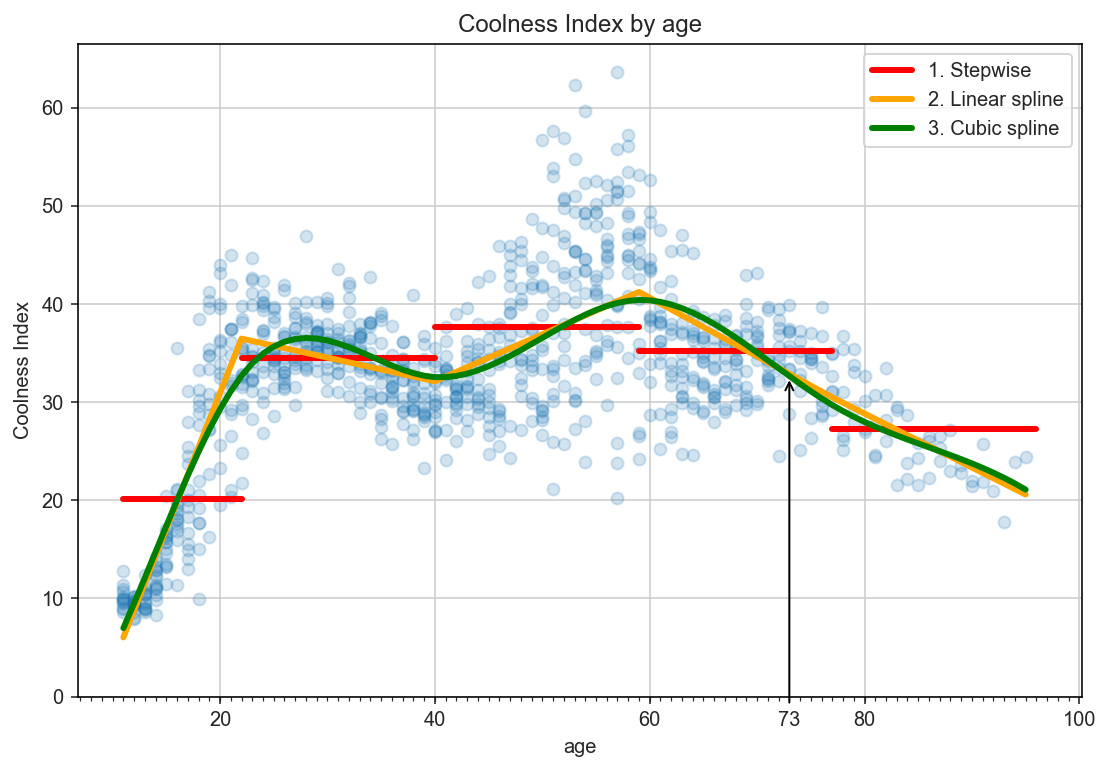

In [29]:
cool73 = spl3(73)

fig, ax = plt.subplots(figsize = (9, 6))
## Cool
plt.scatter(data[:,0], data[:,1], alpha = 0.2)
plt.title('Coolness Index by age')
plt.xlabel('age')
plt.ylabel('Coolness Index')
plt.ylim(0)
ax.set_xticks(np.arange(5,100), minor=True)

## 1. Stepwise
for i in range(4):
    plt.plot((bins[i], bins[i+1]), (stepwise[i],stepwise[i]), c = 'r', linewidth = 3)
plt.plot((bins[4], bins[5]), (stepwise[4],stepwise[4]), c = 'r', linewidth = 3, label = '1. Stepwise')
## 2. Linear spline
plt.plot(data[:,0], spl1(data[:,0]), c = 'orange', linewidth = 3, label = '2. Linear spline')
## 3. Cubic spline
plt.plot(data[:,0], spl3(data[:,0]), c = 'green', linewidth = 3, label = '3. Cubic spline')
plt.legend()

## Coolness of 73-years old 
plt.annotate('73', (73, cool73), (73, -3), arrowprops=dict(arrowstyle='->', ec = 'k'),ha='center');

In [30]:
print('Predicted coolness of a 73-year old: {0:.2f}'.format(cool73))

Predicted coolness of a 73-year old: 32.64
